In [1]:
#라이브러리 로드
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import os
import random
import matplotlib.pyplot as plt
import shutil

from keras.preprocessing.image import load_img 

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

## 0. 상숫값 및 경로 설정

In [7]:
data_dir = 'saves1/' #1.데이터 불러오기 - csv 데이터 폴더 디렉토리
image_dir = "images/" #5.이미지 로드 및 그룹화 - 이미지 폴더 디렉토리
result_dir = "HSVYUV20_GRID5/" #7. 데이터 저장 - 데이터 저장 디렉토리
pca_threshold = 0.99 #3. PCA - 적합한 차원 수 찾기

## 1. 데이터 불러오기

In [8]:
# this list holds all the image filename
file_names = []
data = []

with os.scandir(data_dir) as files:
    for file in files:
        # 모든 csv 파일 읽어오기
        if file.name.endswith('csv'):
            file_names.append(data_dir + file.name)
            
#for file in file_names:
#    now = pd.read_csv(file, header = 0, index_col = 0).to_numpy()
#    data.append(now)

In [99]:
def flatten_with_rgb(data, div, scale):
    flt_data = []
    for feature in data: 
        r = (feature[:,0] / div[0]).astype(int)
        g = (feature[:,1] / div[1]).astype(int)
        b = (feature[:,2] / div[2]).astype(int)
        tar = g * scale[1] * scale[2] + r * scale[2] + b
        
        new_row = np.zeros(scale[0] * scale[1] * scale[2])
        for num, val in zip(tar, data[0][:, 3]):
            new_row[num] += val #+ (0.01 * num)
            
        flt_data.append(new_row)
    return flt_data

In [100]:
flt_data = flatten_with_rgb(data, (51.2,51.2,51.2), (5,5,5))
#flt_data = np.array(data).reshape(-1, 768)

In [101]:
def pca_test(data, threshold):
    pca = PCA(n_components = len(data[0]), random_state = 2021)
    pca.fit_transform(data)
    
    ratio = np.cumsum(pca.explained_variance_ratio_)
    d = np.argmax(ratio >= threshold) + 1    
    return (d, ratio[d - 1])

In [102]:
pca_component = pca_test(flt_data, pca_threshold)
pca_component

(67, 0.9903584693348101)

In [103]:
pca = PCA(n_components = pca_component[0], random_state = 2021)
pca_data = pca.fit_transform(flt_data)

In [355]:
def show_inertia(data, s, e):
    sse = []
    list_k = list(range(s, e))
    for k in tqdm(range(s, e)):
        km = KMeans(n_clusters=k, random_state=22)
        km.fit_transform(data)
        sse.append(km.inertia_)
    plt.figure(figsize=(6, 6))
    plt.plot(list_k, sse)
    plt.xlabel(r'Number of clusters *k*')
    plt.ylabel('Sum of squared distance')

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [00:28<00:00,  1.56s/it]


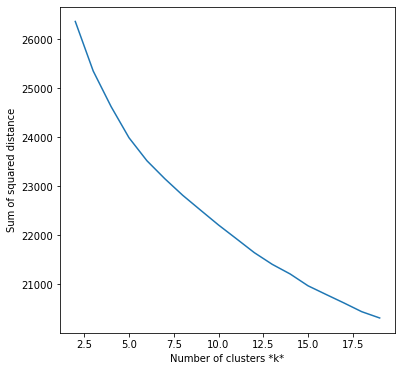

In [356]:
show_inertia(pca_data, 2, 20)

In [104]:
def clustering_data(data, target_cluster = 50):
    kmeans = KMeans(n_clusters=target_cluster, random_state=22)
    return kmeans.fit(data)

In [105]:
clu_data = clustering_data(pca_data)

In [106]:
image_file_names = []

for file in file_names:
    image_file_names.append(image_dir + file.rsplit('.')[0].rsplit('/')[1] + '.jpg')

In [107]:
def grouping_by_clusters(image_file_names, labels):
    groups = {}
    for file, cluster in zip(image_file_names, labels):
        if cluster not in groups.keys():
            groups[cluster] = []
            groups[cluster].append(file)
        else:
            groups[cluster].append(file)
    return groups

In [108]:
groups = grouping_by_clusters(image_file_names, clu_data.labels_)

In [109]:
def view_cluster(groups, cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 24:
        print(f"Clipping cluster size from {len(files)} to 24")
        files = files[:24]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(8, 8,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

Clipping cluster size from 91 to 24


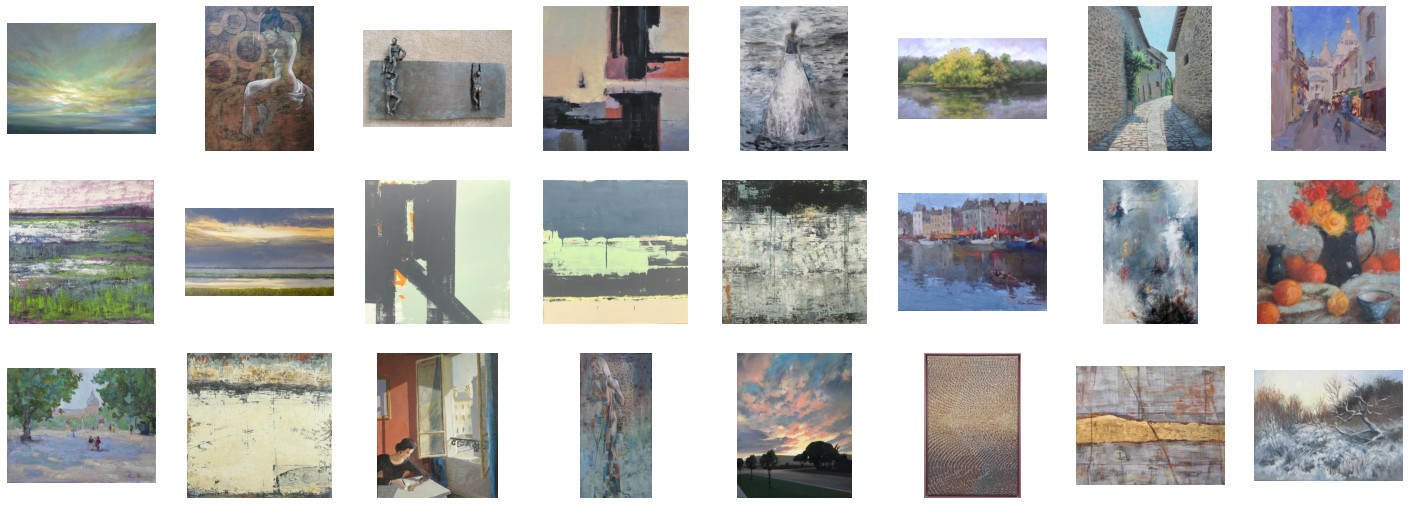

In [110]:
view_cluster(groups, 9)

In [111]:
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

In [112]:
def save_data(groups, result_dir):
    for clusters, files in groups.items():
        createFolder(result_dir + str(clusters))
        for file in files:
            shutil.copyfile(file, result_dir + str(clusters) + '/' + file.rsplit('/')[1])

In [113]:
save_data(groups, result_dir)

'saves1/19079.csv'

In [2]:
cos1 = np.load('cossim1.npy')
cos2 = np.load('cossim2.npy')
cos3 = np.load('cossim3.npy')
cos4 = np.load('cossim4.npy')

In [19]:
x = 35
y = 36
print(file_names[x], file_names[y])
print(100 * cos1[x][y], 100 * cos2[x][y], 100 * cos3[x][y], 100 * cos4[x][y])

saves1/40872.csv saves1/40873.csv
99.53094057622137 98.41478738268222 96.85427283406308 96.97203131780779
